In [24]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
from steam import WebAPI
import time
import os
import glob
import json
import tensorflow as tf
import sys
from IPython import display
import requests
#dont keep api key in github!!!
api_file = os.path.join('..','..','apikeys','steam_api_key.txt')
with open(api_file, 'r') as fin:
    api = WebAPI(key=fin.readline())

In [25]:
#declare interface urls
#dota2_beta should be used for testing in order to not aggressively make API requests
dota2_id = '570'
dota2_beta_id = '205790'

# Get 500 last matches to get approximate hero ratios
Need to be careful here so that test dataset doesn't have crossover with training data. My strategy to eliminate overlap was to start collecting match data for the training set for matches after the oldest match in the test set. To get around the 500 match retrieval limit I save 500 at a time to a .csv with a filename that has the start and end match_id. This means I can get 500, wait a bit, then get 500 more that are guarenteed to not have overlap. 

How long do I have to wait to get 500 more?? Unclear and was unable to find documentation. Thanks Valve.

In [15]:
#get matches data from dota2 API and put IDs into a dataframe
num_requested = 1000
skill = 3
match_list = []

#put a start match_id if I'm trying to get more matches after getting 500
#if trying to load starting from a match_id previously obtained and saved
#use arg: start_at_match_id = old_match_list[-1]-1
matches = api.call('IDOTA2Match_' + dota2_id +'.GetMatchHistory',
                                            hero_id = 121,
                                            game_mode = 1,
                                            skill = skill,
                                            min_players = 10,
                                            matches_requested = 100)

#@TODO: check if lobby_type is public/ranked matching (0 or 7) before appending
[match_list.append(match['match_id']) for match in matches['result']['matches']]

current_num = 100

while current_num <= num_requested:
    
    #check that match request returned any matches before trying to get more
    if len(match_list)==0:
        print('No matches returned\nWait a bit and retry\n\n    GabeN Bless')
    
    #sleep so we don't overload the servers
    time.sleep(1)
                
    current_num += 100
    matches = api.call('IDOTA2Match_' + dota2_id+'.GetMatchHistory',
                                            start_at_match_id = match_list[-1]-1,
                                            game_mode = 1,
                                            skill = skill,
                                            min_players = 10,
                                            matches_requested = 100)

    #@TODO: check if lobby_type is public/ranked matching (0 or 7) before appending
    [match_list.append(match['match_id']) for match in matches['result']['matches']]

    
dota2_test_df = pd.DataFrame()
dota2_test_df['match_id'] = match_list

In [21]:
#get match details from match_ids obtained
#add radiant_win column
#add heroes split between dire and radiant

radiant_win_column = []
radiant_hero_column = []
dire_hero_column = []
match_details = []

for match_id in dota2_test_df['match_id']:
    time.sleep(1)
    match_details.append(api.call('IDOTA2Match_' + dota2_id+'.GetMatchDetails',
                                  match_id = str(match_id)))
    radiant_win_column.append(match_details[-1]['result']['radiant_win'])
    
    radiant_hero_row = []
    dire_hero_row = []
    for player in match_details[-1]['result']['players']:
        #First bit of 8-bit integer player_slot is 1 if the player was on dire
        #so if player was on dire then player_slot > 128
        if player['player_slot']/128<1:
            radiant_hero_row.append(player['hero_id'])
        else:
            dire_hero_row.append(player['hero_id'])
    
    radiant_hero_column.append(radiant_hero_row)
    dire_hero_column.append(dire_hero_row)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
#Add radiant_win column to Dataframe
dota2_test_df['radiant_win'] = 1*np.array(radiant_win_column)

#Add dire and radiant heroes to DataFrame under their own columns
for i in range(len(np.array(radiant_hero_column)[0])):
    dota2_test_df['radiant_heroes'+str(i)] = np.array(radiant_hero_column)[:,i]
    dota2_test_df['dire_heroes'+str(i)] = np.array(dire_hero_column)[:,i]

In [28]:
#save data to csv file so that we have it on disk
dota2_test_df.to_csv(os.path.join('dota2_test_data',
                                        str(dota2_test_df['match_id'][0])+
                                        '-'+
                                        str(dota2_test_df['match_id'][499])+'.csv'))

# Load test data that is newest for match_id checking

In [127]:
#Run this if the test data is needed to allow for proper test_data collection
#load newest file so that last_match_id is accurate? Unclear if this is the best strategy... 
#maybe should look at loading all then looking at match_id
dota2_data_files = glob.glob(os.path.join('dota2_test_data','*.csv'))
dota2_data_files.sort(key=os.path.getmtime)

dota2_test_df_from_file = pd.read_csv(dota2_data_files[0], usecols=range(1,13))
dota2_test_df_from_file.style

#purge 0 values from hero_id
dota2_test_df_from_file = dota2_test_df_from_file[dota2_test_df_from_file.radiant_heroes0 != 0]

#make old_match_list for easy checking of match_id
old_match_list = list(dota2_test_df_from_file['match_id'])

# Get 500 matches of each hero id (and trim duplicates)

In [26]:
hero_list = api.call('IEconDOTA2_'+dota2_id+'.GetHeroes',itemizedonly = True)
hero_list=pd.DataFrame(hero_list['result']['heroes'])

## Get match_id of all the matches
this uses GetMatchHistory which is a bit limits match getting to 500 per hero (about 2e4) and sometimes stops returning matches

In [63]:
#get matches data from dota2 API and put IDs into a dataframe
num_matches_to_request = 500
skill = 3
match_list = []
most_current_matches = True

#Loop through all hero_id values
#use vocabulary generated by an api call above to get all hero id's
for i in hero_list['id']:
    
    #Get first match for each hero out of loop so that we can pull more than 100 games per hero
    #by utilizing start_at_match_id option
    if most_current_matches==True:
        matches = api.call('IDOTA2Match_' + dota2_id+'.GetMatchHistory',hero_id = i,
                                                                   game_mode = 1,
                                                                   skill = skill,
                                                                   min_players = 10,
                                                                   matches_requested = 100)
    else:
        files=glob.glob(os.path.join('Dota_data','skill_level='+str(skill),'*.csv'))
        files.sort(key=os.path.getmtime)
        start_match = pd.read_csv(files[-1], usecols=[1])['match_id'].min()-1
        print(start_match)
        matches = api.call('IDOTA2Match_' + dota2_id+'.GetMatchHistory',hero_id=i,
                                                            start_at_match_id=start_match,
                                                            game_mode=1,
                                                            skill=skill,
                                                            min_players=10,
                                                            matches_requested=100)
    #Append matches to matchlist
    #if lobby_type is public/ranked matching (0 or 7)
    for match in matches['result']['matches']:
        lobby_type=match['lobby_type']
        if lobby_type==0 or lobby_type==7 or lobby_type==5 or lobby_type==2:
            match_list.append(match['match_id'])
            
    current_num = 1

    if len(match_list)==0:
        print('No matches returned\nWait a bit and retry\n\n    GabeN Bless')
        break
    
    while current_num <= num_matches_to_request:
        #sleep so we don't overload the servers
        time.sleep(1)

        current_num += 100
        matches = api.call('IDOTA2Match_' + dota2_id+'.GetMatchHistory',hero_id = i,
                                                        start_at_match_id = match_list[-1]-1,
                                                        game_mode = 1,
                                                        skill = skill,
                                                        min_players = 10,
                                                        matches_requested = 100)
        
        #Append matches to matchlist
        #if lobby_type is public/ranked matching (0 or 7)
        for match in matches['result']['matches']:
            lobby_type=match['lobby_type']
            if lobby_type==0 or lobby_type==7 or lobby_type==5 or lobby_type==2:
                match_list.append(match['match_id'])


## Purge duplicates and add to dataframe

In [64]:
#Make dataframe of match_id values using dict.fromkeys(list) to remove duplicates
dota2_df = pd.DataFrame()
dota2_df['match_id'] = list(dict.fromkeys(match_list))

dota2_df.describe()

,match_id
count,1.153900e+04
mean,4.780880e+09
std,1.187805e+05
min,4.780264e+09
25%,4.780821e+09
50%,4.780893e+09
75%,4.780967e+09
max,4.781085e+09


## Save match id list

In [65]:
dota2_df.to_csv(os.path.join('Dota_data',
                                      'skill_level='+str(skill),
                                      'saved'+time.strftime('%Y-%m-%d')+'.csv'))

# Get match details for matches
this is a poor way to do it because it needs many calls to get the data. GetMatchHistoryBySequenceNum is nice but there are no filters so the usable matches are ~1/500.

## Load files of match_ids

In [205]:
dota_df = None

files=glob.glob(os.path.join('Dota_data','skill_level=*','*.csv'))
files.sort(key=os.path.getmtime)
#print(files)
for filename in files[:]:
    print(filename)
    if type(dota_df)==None:
        dota_df = pd.read_csv(filename, usecols=[1])
        dota_df['skill_level'] = np.ones(len(dota_df['match_id']))*int(filename[-21])
    else:
        dota_df_new = pd.read_csv(filename, usecols=[1])
        dota_df_new['skill_level'] = np.ones(len(dota_df_new['match_id']))*int(filename[-21])
        dota_df = pd.concat([dota_df, dota_df_new],
                                                    ignore_index=True)

dota_df.describe()

Dota_data/skill_level=3/saved2019-05-06.csv
Dota_data/skill_level=2/saved2019-05-06.csv
Dota_data/skill_level=1/saved2019-05-06.csv
Dota_data/skill_level=3/saved2019-05-08.csv
Dota_data/skill_level=2/saved2019-05-08.csv
Dota_data/skill_level=1/saved2019-05-08.csv
Dota_data/skill_level=1/saved2019-05-12.csv
Dota_data/skill_level=2/saved2019-05-12.csv
Dota_data/skill_level=3/saved2019-05-12.csv
Dota_data/skill_level=1/saved2019-05-13.csv
Dota_data/skill_level=2/saved2019-05-13.csv
Dota_data/skill_level=3/saved2019-05-13.csv
Dota_data/skill_level=1/saved2019-05-20.csv
Dota_data/skill_level=2/saved2019-05-20.csv
Dota_data/skill_level=3/saved2019-05-21.csv
Dota_data/skill_level=1/saved2019-05-22.csv
Dota_data/skill_level=2/saved2019-05-22.csv
Dota_data/skill_level=3/saved2019-05-22.csv
Dota_data/skill_level=3/saved2019-05-23.csv
Dota_data/skill_level=2/saved2019-05-23.csv
Dota_data/skill_level=1/saved2019-05-23.csv
Dota_data/skill_level=1/saved2019-05-24.csv
Dota_data/skill_level=2/saved201

,match_id,skill_level
count,2.878220e+05,287822.000000
mean,4.757200e+09,1.972292
std,1.988449e+07,0.821628
min,4.725403e+09,1.000000
25%,4.733830e+09,1.000000
50%,4.749397e+09,2.000000
75%,4.775588e+09,3.000000
max,4.781085e+09,3.000000


## Get the details

In [165]:
#initialize data columns if you're starting a match_detail getting batch
#if trying to finish one that broke unexpectedly then don't!
radiant_win_column = []
radiant_xp_column = []; dire_xp_column = []
radiant_gold_column = []; dire_gold_column = []
radiant_healing_column = []; dire_healing_column = []
radiant_towerdamage_column = []; dire_towerdamage_column =[]
radiant_kills_column = []; dire_kills_column = []
radiant_hero_column = []; dire_hero_column = []
match_id_list=[]
positive_votes_column=[]; negative_votes_column=[]
duration_column=[]
skill_column=[]

In [167]:
#get match details from match_ids obtained
#add radiant_win column
#add heroes split between dire and radiant

for i,match_id in enumerate(dota_df[:]['match_id']):
    time.sleep(1)
    
    try:
        match_details = api.call('IDOTA2Match_' + dota2_id+'.GetMatchDetails'
                                  ,match_id = str(match_id))
    except:
        print('server error at match_id: ' + str(match_id))
        print('element:',i,' match_id:',match_id)
        time.sleep(10)
        continue
         
    dire_xp = 0; radiant_xp = 0    
    dire_gold = 0; radiant_gold = 0
    dire_healing = 0; radiant_healing = 0
    dire_kills = 0; radiant_kills = 0
    dire_towerdamage = 0; radiant_towerdamage = 0
    dire_healing = 0; radiant_healing = 0
    radiant_hero_row = []; dire_hero_row = []
    #get heroes, xp, and gold for features, target, target
    for player in match_details['result']['players']:
        #First bit of 8-bit integer player_slot is 1 if the player was on dire
        #so if player was on dire then player_slot > 128
        if player['player_slot']/128<1:
            radiant_hero_row.append(player['hero_id'])
            radiant_xp+=player['xp_per_min']*match_details['result']['duration']/60
            radiant_gold+=player['gold_spent']
            radiant_kills+=player['kills']
            radiant_healing+=player['hero_healing']
            radiant_towerdamage+=player['tower_damage']
        else:
            dire_hero_row.append(player['hero_id'])
            dire_xp+=player['xp_per_min']*match_details['result']['duration']/60
            dire_gold+=player['gold_spent']
            dire_kills+=player['kills']
            dire_healing+=player['hero_healing']
            dire_towerdamage+=player['tower_damage']
    
    skill_column = int(dota_df['skill_level'][i])
    radiant_win_column.append(match_details['result']['radiant_win'])

    dire_xp_column.append(dire_xp)
    radiant_xp_column.append(radiant_xp)
    radiant_gold_column.append(radiant_gold)
    dire_gold_column.append(dire_gold)
    radiant_kills_column.append(radiant_kills)
    dire_kills_column.append(dire_kills)
    #radiant healing appears to be bugged as of 20190609, but my code is identical to dire?
    radiant_healing_column.append(radiant_healing)
    dire_healing_column.append(dire_healing)
    radiant_towerdamage_column.append(radiant_towerdamage)
    dire_towerdamage_column.append(dire_towerdamage)
    
    positive_votes_column.append(match_details['result']['positive_votes'])
    negative_votes_column.append(match_details['result']['negative_votes'])
    duration_column.append(match_details['result']['duration'])               

    radiant_hero_column.append(radiant_hero_row)
    dire_hero_column.append(dire_hero_row)
    match_id_list.append(match_id)
    if len(radiant_win_column)!= len(match_id_list):
        print('length mismatch!')
        break

server error at match_id: 4733817248
element: 53708  match_id: 4733817248
server error at match_id: 4733814864
element: 53709  match_id: 4733814864
server error at match_id: 4733814783
element: 53710  match_id: 4733814783
server error at match_id: 4733812376
element: 53711  match_id: 4733812376
server error at match_id: 4733811954
element: 53712  match_id: 4733811954
server error at match_id: 4733811735
element: 53713  match_id: 4733811735
server error at match_id: 4733810773
element: 53714  match_id: 4733810773
server error at match_id: 4733810018
element: 53715  match_id: 4733810018
server error at match_id: 4733809433
element: 53716  match_id: 4733809433
server error at match_id: 4733808305
element: 53717  match_id: 4733808305
server error at match_id: 4733808077
element: 53718  match_id: 4733808077
server error at match_id: 4733807209
element: 53719  match_id: 4733807209
server error at match_id: 4733806907
element: 53720  match_id: 4733806907
server error at match_id: 4733806167
e

server error at match_id: 4746524233
element: 103841  match_id: 4746524233
server error at match_id: 4746523639
element: 103842  match_id: 4746523639
server error at match_id: 4746523527
element: 103843  match_id: 4746523527
server error at match_id: 4746523037
element: 103844  match_id: 4746523037
server error at match_id: 4746522032
element: 103845  match_id: 4746522032
server error at match_id: 4746521906
element: 103846  match_id: 4746521906
server error at match_id: 4746521640
element: 103847  match_id: 4746521640
server error at match_id: 4746520963
element: 103848  match_id: 4746520963
server error at match_id: 4746519626
element: 103849  match_id: 4746519626
server error at match_id: 4746516188
element: 103852  match_id: 4746516188
server error at match_id: 4746516105
element: 103853  match_id: 4746516105
server error at match_id: 4746513814
element: 103856  match_id: 4746513814
server error at match_id: 4746512752
element: 103857  match_id: 4746512752
server error at match_id:

server error at match_id: 4746442485
element: 103995  match_id: 4746442485
server error at match_id: 4746440130
element: 103998  match_id: 4746440130
server error at match_id: 4746439765
element: 103999  match_id: 4746439765
server error at match_id: 4746438487
element: 104000  match_id: 4746438487
server error at match_id: 4746438352
element: 104001  match_id: 4746438352
server error at match_id: 4746437447
element: 104002  match_id: 4746437447
server error at match_id: 4746435594
element: 104005  match_id: 4746435594
server error at match_id: 4746435257
element: 104006  match_id: 4746435257
server error at match_id: 4746435016
element: 104007  match_id: 4746435016
server error at match_id: 4746434961
element: 104008  match_id: 4746434961
server error at match_id: 4746434489
element: 104009  match_id: 4746434489
server error at match_id: 4746434364
element: 104010  match_id: 4746434364
server error at match_id: 4746434250
element: 104011  match_id: 4746434250
server error at match_id:

server error at match_id: 4775572565
element: 189672  match_id: 4775572565
server error at match_id: 4775572473
element: 189673  match_id: 4775572473
server error at match_id: 4775572335
element: 189674  match_id: 4775572335
server error at match_id: 4777944854
element: 237461  match_id: 4777944854
server error at match_id: 4777938239
element: 237462  match_id: 4777938239
server error at match_id: 4777934737
element: 237463  match_id: 4777934737
server error at match_id: 4777928834
element: 237465  match_id: 4777928834
server error at match_id: 4777928543
element: 237466  match_id: 4777928543
server error at match_id: 4777925837
element: 237468  match_id: 4777925837
server error at match_id: 4777916151
element: 237474  match_id: 4777916151
server error at match_id: 4777912589
element: 237475  match_id: 4777912589
server error at match_id: 4777912115
element: 237476  match_id: 4777912115
server error at match_id: 4777907428
element: 237477  match_id: 4777907428
server error at match_id:

server error at match_id: 4780746714
element: 274846  match_id: 4780746714
server error at match_id: 4780857348
element: 275502  match_id: 4780857348


In [168]:
print(len(radiant_hero_column))
print(len(dota_df['match_id']))
print(len(match_id_list))

287416
287822
287416


### Run if the match_detail fetching broke and the df length is different from the data column lengths

In [85]:
match_id_list = []
match_details = list(match_details)
radiant_win_column = []
radiant_xp_column = []
dire_xp_column = []
radiant_gold_column = []
dire_gold_column = []
radiant_hero_column = []
dire_hero_column = []

for i,match in enumerate(match_details):
    
    match_id_list.append(match['result']['match_id'])
    radiant_win_column.append(match['result']['radiant_win'])
    
    dire_xp = 0; radiant_xp = 0    
    dire_gold = 0; radiant_gold = 0
    radiant_hero_row = []; dire_hero_row = []
    #get heroes, xp, and gold for features, target, target
    for player in match_details[i]['result']['players']:
        #First bit of 8-bit integer player_slot is 1 if the player was on dire
        #so if player was on dire then player_slot > 128
        if player['player_slot']/128<1:
            radiant_hero_row.append(player['hero_id'])
            radiant_xp+=player['xp_per_min']*match_details[i]['result']['duration']/60
            for item_index in range(5):
                radiant_gold+=item_df.loc[item_df['id']==player['item_'+str(item_index)]]['cost']
        else:
            dire_hero_row.append(player['hero_id'])
            dire_xp+=player['xp_per_min']*match_details[i]['result']['duration']/60
            for item_index in range(5):
                dire_gold+=item_df.loc[item_df['id']==player['item_'+str(item_index)]]['cost']

    dire_xp_column.append(dire_xp)
    radiant_xp_column.append(radiant_xp)
    radiant_gold_column.append(radiant_gold)
    dire_gold_column.append(dire_gold)
    radiant_hero_column.append(radiant_hero_row)
    dire_hero_column.append(dire_hero_row)
dota2_training_df = pd.DataFrame()
dota2_training_df['match_id'] = match_id_list

TypeError: string indices must be integers

## Process and save data

In [174]:
dota2_training_df = pd.DataFrame()
#Add radiant_win column to DataFrame
dota2_training_df['radiant_win'] = 1*np.array(radiant_win_column)

#add xp and gold columns to DataFrame
dota2_training_df['radiant_xp'] = np.array(radiant_xp_column)
dota2_training_df['dire_xp'] = np.array(dire_xp_column)
dota2_training_df['radiant_gold'] = np.array(radiant_gold_column)
dota2_training_df['dire_gold'] = np.array(dire_gold_column)

#add kills, healing, towerdamage, duration, and positive/negative votes
dota2_training_df['radiant_kills'] = np.array(radiant_kills_column)
dota2_training_df['dire_kills'] = np.array(dire_kills_column)
dota2_training_df['radiant_healing'] = np.array(radiant_healing_column)
dota2_training_df['dire_healing'] = np.array(dire_healing_column)
dota2_training_df['radiant_towerdamage'] = np.array(radiant_towerdamage_column)
dota2_training_df['dire_towerdamage'] = np.array(dire_towerdamage_column)
dota2_training_df['radiant_healing'] = np.array(positive_votes_column)
dota2_training_df['radiant_healing'] = np.array(negative_votes_column)
dota2_training_df['duration'] = np.array(duration_column.append)
dota2_training_df['negative_votes'] = np.array(negative_votes_column)
dota2_training_df['positive_votes'] = np.array(positive_votes_column)

#add match_id
dota2_training_df['match_id'] = match_id_list

#Add dire and radiant heroes to DataFrame under their own columns
for i in range(len(np.array(radiant_hero_column)[0])):
    print(i)
    dota2_training_df['radiant_heroes'+str(i)] = np.array(radiant_hero_column)[:,i]
    dota2_training_df['dire_heroes'+str(i)] = np.array(dire_hero_column)[:,i]

0
1
2
3
4


In [175]:
#purge 0 values from hero_id
dota2_training_df = dota2_training_df[dota2_training_df.radiant_heroes0 != 0]


In [186]:
#save data to csv file so we have it on disk
dota2_training_df.to_csv(os.path.join('Dota_data',
                                        'mixed_skill',
                                        str(dota2_training_df['match_id'].min())+
                                        '-'+
                                        str(dota2_training_df['match_id'].max())+
                                        '.csv'))

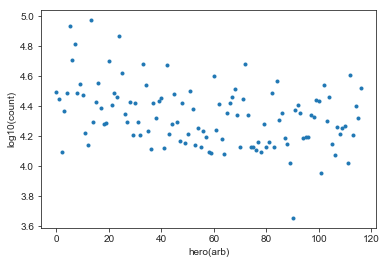

In [177]:
sns.set_style('ticks')
champ_sum = np.concatenate((dota2_training_df['radiant_heroes0'],
                            dota2_training_df['radiant_heroes1'],
                            dota2_training_df['radiant_heroes2'],
                            dota2_training_df['radiant_heroes3'],
                            dota2_training_df['radiant_heroes4'],
                            dota2_training_df['dire_heroes0'],
                            dota2_training_df['dire_heroes1'],
                            dota2_training_df['dire_heroes2'],
                            dota2_training_df['dire_heroes3'],
                            dota2_training_df['dire_heroes4']),axis=None)

unique, counts = np.unique(champ_sum, return_counts=True)

plt.plot(np.log10(counts),'.')
plt.xlabel('hero(arb)')
plt.ylabel('log10(count)')
plt.show()

# Get many matches using GetMatchHistoryBySequence

In [251]:
files=glob.glob(os.path.join('Dota_data','mixed_skill','*.csv'))
files.sort(key=os.path.getmtime)
print(files)

['Dota_data/mixed_skill/4700715544-4714025416.csv', 'Dota_data/mixed_skill/4713667803-4713667803.csv', 'Dota_data/mixed_skill/4703186847-4705923169.csv', 'Dota_data/mixed_skill/4705745435-4706747732.csv']


In [223]:
#open all recent data files then use the oldest one to set the initial
#    match_seq_num to use to get matches by GetMatchHistoryBySequenceNum
#TODO: write option to start from a recent match
files=glob.glob(os.path.join('Dota_data','mixed_skill,'*.csv'))
files.sort(key=os.path.getmtime)
start_match = pd.read_csv(files[-1], usecols=[1])['match_id'].iloc[-1]
start_match_seq_num = api.call('IDOTA2Match_'+dota2_id+'.GetMatchDetails',
                        match_id=start_match)['result']['match_seq_num']

num_requested=1e7
match_dict = api.call('IDOTA2Match_'+dota2_id+'.GetMatchHistoryBySequenceNum',
                      start_at_match_seq_num=start_match_seq_num,
                    matches_requested=100)
match_list = match_dict['result']['matches']

consec_err=0
while num_requested>len(match_list):
    time.sleep(1)
    try:
        match_dict=(api.call('IDOTA2Match_'+dota2_id+'.GetMatchHistoryBySequenceNum',
                start_at_match_seq_num=match_list[-1]['match_seq_num'],
                    matches_requested=100))
        match_list.extend(match_dict['result']['matches'])
        consec_err=0
    except requests.exceptions.HTTPError as err:
        print(err)
        if consec_err>2:
            print('triple error')
            break
        else:
            print(len(match_list))
            consec_err+=1
            time.sleep(30)

429 Client Error: Too Many Requests for url: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1/?key=7F44F34FA4A40E5AAC85F14565010E8C&format=json&start_at_match_seq_num=3977598904&matches_requested=1000
1700
429 Client Error: Too Many Requests for url: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1/?key=7F44F34FA4A40E5AAC85F14565010E8C&format=json&start_at_match_seq_num=3977602254&matches_requested=1000
3300
429 Client Error: Too Many Requests for url: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1/?key=7F44F34FA4A40E5AAC85F14565010E8C&format=json&start_at_match_seq_num=3977605201&matches_requested=1000
4700
429 Client Error: Too Many Requests for url: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1/?key=7F44F34FA4A40E5AAC85F14565010E8C&format=json&start_at_match_seq_num=3977607771&matches_requested=1000
5900
429 Client Error: Too Many Requests for url: https://api.steampo

429 Client Error: Too Many Requests for url: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1/?key=7F44F34FA4A40E5AAC85F14565010E8C&format=json&start_at_match_seq_num=3977687495&matches_requested=1000
38200
429 Client Error: Too Many Requests for url: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1/?key=7F44F34FA4A40E5AAC85F14565010E8C&format=json&start_at_match_seq_num=3977691538&matches_requested=1000
39700
429 Client Error: Too Many Requests for url: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1/?key=7F44F34FA4A40E5AAC85F14565010E8C&format=json&start_at_match_seq_num=3977691538&matches_requested=1000
39700
429 Client Error: Too Many Requests for url: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1/?key=7F44F34FA4A40E5AAC85F14565010E8C&format=json&start_at_match_seq_num=3977695012&matches_requested=1000
40900
429 Client Error: Too Many Requests for url: https://api.ste

429 Client Error: Too Many Requests for url: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1/?key=7F44F34FA4A40E5AAC85F14565010E8C&format=json&start_at_match_seq_num=3977784526&matches_requested=1000
71600
429 Client Error: Too Many Requests for url: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1/?key=7F44F34FA4A40E5AAC85F14565010E8C&format=json&start_at_match_seq_num=3977787962&matches_requested=1000
72700
429 Client Error: Too Many Requests for url: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1/?key=7F44F34FA4A40E5AAC85F14565010E8C&format=json&start_at_match_seq_num=3977787962&matches_requested=1000
72700
429 Client Error: Too Many Requests for url: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1/?key=7F44F34FA4A40E5AAC85F14565010E8C&format=json&start_at_match_seq_num=3977791356&matches_requested=1000
73800
429 Client Error: Too Many Requests for url: https://api.ste

429 Client Error: Too Many Requests for url: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1/?key=7F44F34FA4A40E5AAC85F14565010E8C&format=json&start_at_match_seq_num=3977888535&matches_requested=1000
105000
429 Client Error: Too Many Requests for url: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1/?key=7F44F34FA4A40E5AAC85F14565010E8C&format=json&start_at_match_seq_num=3977892429&matches_requested=1000
106300
429 Client Error: Too Many Requests for url: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1/?key=7F44F34FA4A40E5AAC85F14565010E8C&format=json&start_at_match_seq_num=3977896774&matches_requested=1000
107700
429 Client Error: Too Many Requests for url: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1/?key=7F44F34FA4A40E5AAC85F14565010E8C&format=json&start_at_match_seq_num=3977900542&matches_requested=1000
109000
429 Client Error: Too Many Requests for url: https://api

429 Client Error: Too Many Requests for url: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1/?key=7F44F34FA4A40E5AAC85F14565010E8C&format=json&start_at_match_seq_num=3977989949&matches_requested=1000
140500
429 Client Error: Too Many Requests for url: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1/?key=7F44F34FA4A40E5AAC85F14565010E8C&format=json&start_at_match_seq_num=3977992462&matches_requested=1000
141400
429 Client Error: Too Many Requests for url: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1/?key=7F44F34FA4A40E5AAC85F14565010E8C&format=json&start_at_match_seq_num=3977992768&matches_requested=1000
141500
429 Client Error: Too Many Requests for url: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1/?key=7F44F34FA4A40E5AAC85F14565010E8C&format=json&start_at_match_seq_num=3977995936&matches_requested=1000
142600
429 Client Error: Too Many Requests for url: https://api

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [249]:
consec_err=0
num_requested=2e5
match_list=[match_list[-1]]
while num_requested>len(match_list):
    time.sleep(1)
    try:
        match_dict=(api.call('IDOTA2Match_'+dota2_id+'.GetMatchHistoryBySequenceNum',
                start_at_match_seq_num=match_list[-1]['match_seq_num'],
                    matches_requested=100))
        match_list.extend(match_dict['result']['matches'])
        consec_err=0
    except requests.exceptions.HTTPError as err:
        print(err)
        if consec_err>2:
            print('triple error')
            break
        else:
            print(len(match_list))
            consec_err+=1
            time.sleep(30)
match_list=match_list[1:]

KeyboardInterrupt: 

In [246]:
print(len(match_list))

143801


In [247]:
radiant_win_column = []; radiant_xp_column = []; dire_xp_column = []; radiant_gold_column = []
dire_gold_column = []; radiant_hero_column = []; dire_hero_column = []; match_id_list = []
match_seq_num_list = []

for match in match_list:
    
    if (match['game_mode']!=1 and match['game_mode']!=2) or match['human_players']!=10:
        continue
    
    match_id_list.append(match['match_id'])
    match_seq_num_list.append(match['match_seq_num'])
    radiant_win_column.append(match['radiant_win'])
    
    dire_xp = 0; radiant_xp = 0    
    dire_gold = 0; radiant_gold = 0
    radiant_hero_row = []; dire_hero_row = []
    #get heroes, xp, and gold for features, target, target
    for player in match['players']:
        #First bit of 8-bit integer player_slot is 1 if the player was on dire
        #so if player was on dire then player_slot > 128
        if player['player_slot']/128<1:
            radiant_hero_row.append(player['hero_id'])
            radiant_xp+=player['xp_per_min']*match['duration']/60
            for item_index in range(5):
                if player['item_'+str(item_index)]!=0:
                    radiant_gold+=int(item_df.loc[item_df['id']==player['item_'+str(item_index)]]['cost'])
        else:
            dire_hero_row.append(player['hero_id'])
            dire_xp+=player['xp_per_min']*match['duration']/60
            for item_index in range(5):
                if player['item_'+str(item_index)]!=0:
                    dire_gold+=int(item_df.loc[item_df['id']==player['item_'+str(item_index)]]['cost'])

    dire_xp_column.append(dire_xp)
    radiant_xp_column.append(radiant_xp)
    radiant_gold_column.append(radiant_gold)
    dire_gold_column.append(dire_gold)
    radiant_hero_column.append(radiant_hero_row)
    dire_hero_column.append(dire_hero_row)

In [248]:
print(len(match_id_list))

206


In [25]:
dota2_training_df = pd.DataFrame()

#Add radiant_win column to DataFrame
dota2_training_df['radiant_win'] = 1*np.array(radiant_win_column)

#add xp and gold columns to DataFrame
dota2_training_df['radiant_xp'] = np.array(radiant_xp_column)
dota2_training_df['dire_xp'] = np.array(dire_xp_column)
dota2_training_df['radiant_gold'] = np.array(radiant_gold_column)
dota2_training_df['dire_gold'] = np.array(dire_gold_column)

#add match_id and match_seq_num
dota2_training_df['match_id'] = np.array(match_id_list)
#dota2_training_df['match_seq_num'] = np.array(match_seq_num_list)


#Add dire and radiant heroes to DataFrame under their own columns
for i in range(len(np.array(radiant_hero_column)[0])):
    print(i)
    dota2_training_df['radiant_heroes'+str(i)] = np.array(radiant_hero_column)[:,i]
    dota2_training_df['dire_heroes'+str(i)] = np.array(dire_hero_column)[:,i]

0
1
2
3
4


In [26]:
#purge 0 values from hero_id
dota2_training_df = dota2_training_df[dota2_training_df.radiant_heroes0 != 0]

In [27]:
#save data to csv file so we have it on disk
dota2_training_df.to_csv(os.path.join('Dota_data',
                                        'mixed_skill',
                                        str(dota2_training_df['match_id'].min())+
                                        '-'+
                                        str(dota2_training_df['match_id'].max())+
                                        '.csv'))

# Build TFRecords file
Puts all training data in the training_data folder into one TFRecords file
Do this to nicely handle the features that are numpy arrays (radiant_heroes and dire_heroes)

In [199]:
dota2_df = None
files=glob.glob(os.path.join('Dota_data','mixed_skill','*.csv'))
files.sort(key=os.path.getmtime)
print(files[0])
for filename in files[-1:]:
    if type(dota2_df)==None:
        dota2_df = pd.read_csv(filename, usecols=range(1,26))
    else:
        dota2_df = pd.concat([dota2_df, pd.read_csv(filename, usecols=range(1,26))],ignore_index=True)

dota2_df = dota2_df.reindex(np.random.permutation(dota2_df.index))
dota2_df.describe()

Dota_data/mixed_skill/4725403110-4775693839.csv


,radiant_win,radiant_xp,dire_xp,radiant_gold,dire_gold,radiant_kills,dire_kills,radiant_healing,dire_healing,radiant_towerdamage,...,radiant_heroes0,dire_heroes0,radiant_heroes1,dire_heroes1,radiant_heroes2,dire_heroes2,radiant_heroes3,dire_heroes3,radiant_heroes4,dire_heroes4
count,287416.000000,287416.000000,287416.000000,287416.000000,287416.000000,287416.000000,287416.000000,287416.000000,287416.000000,287416.000000,...,287416.000000,287416.000000,287416.000000,287416.000000,287416.000000,287416.000000,287416.000000,287416.000000,287416.000000,287416.000000
mean,0.547402,108936.501296,108245.521488,71398.804068,70517.470061,30.670370,29.847507,0.002272,3692.235954,11538.023850,...,52.834762,52.900604,52.996876,53.116295,52.971891,53.098888,52.903033,53.014484,52.786247,52.950518
std,0.497749,50081.940580,52053.025385,27735.982901,29633.745523,13.389364,14.395740,0.081167,5060.362360,8374.040901,...,35.699988,35.689077,35.789319,35.749345,35.741674,35.747986,35.753247,35.744772,35.769582,35.694289
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,72688.087500,69510.475000,52915.000000,49535.000000,21.000000,19.000000,0.000000,325.000000,2894.000000,...,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
50%,1.000000,105657.850000,105186.833333,69960.000000,69575.000000,31.000000,30.000000,0.000000,1797.000000,12058.000000,...,48.000000,47.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,47.000000,48.000000
75%,1.000000,141294.512500,142534.100000,88110.000000,89235.000000,40.000000,40.000000,0.000000,5111.000000,18838.000000,...,83.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
max,1.000000,542318.266667,507291.733333,291645.000000,266075.000000,112.000000,164.000000,18.000000,88485.000000,37096.000000,...,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000


In [200]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [201]:
def convert_to_tfrecords(filename, examples, targets, target_name):
    # open the TFRecords file
    writer = tf.python_io.TFRecordWriter(filename)
    
    radiant_hero_array = np.array(examples['radiant_heroes'])
    dire_hero_array = np.array(examples['dire_heroes'])
    target_array = np.array(targets[target_name])
    
    for i in range(len(radiant_hero_array[:])):
        # print how many games are saved every 5000 games
        if not i % 5000:
            print('Train data: %d/%d' % (i, len(examples)))
            sys.stdout.flush()
            
        # Load the image
        radiant_heroes = radiant_hero_array[:][i].tostring()
        dire_heroes = dire_hero_array[:][i].tostring()
        target = target_array[i]
        
        # Create a feature
        if target_name=='radiant_win':
            feature = {'radiant_heroes': _bytes_feature(tf.compat.as_bytes(radiant_heroes)),
                   'dire_heroes': _bytes_feature(tf.compat.as_bytes(dire_heroes)),
                   'targets': _int64_feature(target)}
        else:
            feature = {'radiant_heroes': _bytes_feature(tf.compat.as_bytes(radiant_heroes)),
                   'dire_heroes': _bytes_feature(tf.compat.as_bytes(dire_heroes)),
                   'targets': _float_feature(target)}
        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))
    
        # Serialize to string and write on the file
        writer.write(example.SerializeToString())
    
    writer.close()
    sys.stdout.flush()

In [202]:
def preprocess_features(dota2_df):
    """Take dota2_df and create a dataframe containing only the features for our model
            Args: 
                dota2_df: Dataframe containing dota2 training and test data
            returns: 
                processed_df: pandas DataFrame containing only feature columns
    """
    
    #Use arrays of heroes for each team as features rather than each hero
    #individually to help model fit?
    #This is an attempt to make the model more similar to the movie review
    #text analysis example in the Google ML Crash Course
    processed_df = pd.DataFrame()
    
    processed_df['radiant_heroes'] = list(np.array(dota2_df.loc[:,['radiant_heroes0',
                                                'radiant_heroes1','radiant_heroes2',
                                                'radiant_heroes3','radiant_heroes4']]))
    processed_df['dire_heroes'] = list(np.array(dota2_df.loc[:,['dire_heroes0',
                                    'dire_heroes1','dire_heroes2',
                                    'dire_heroes3','dire_heroes4']]))
     
    return processed_df
    
def preprocess_targets_win(dota2_df):
    """Take dota2_df and create a dataframe containing only the targets for our model.
      (radiant_win here)
            Args: 
                dota2_df: Dataframe containing lol training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column
    """
    target_df = pd.DataFrame()
    target_df['radiant_win'] = dota2_df['radiant_win']
    
    return target_df

def preprocess_targets_gold(dota2_df):
    """Take dota2_df and create a dataframe containing only the targets for our model 
        (normalized gold difference in this case)
            Args: 
                dota2_df: Dataframe containing lol training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column (gold_diff)
    """
    target_df = pd.DataFrame()
    target_df['gold_diff'] = (dota2_df['radiant_gold']-dota2_df['dire_gold'])/(dota2_df['radiant_gold']+dota2_df['dire_gold'])
    target_df['gold_diff'] = (target_df['gold_diff']-target_df['gold_diff'].mean())/target_df['gold_diff'].std()
    return target_df

def preprocess_targets_xp(dota2_df):
    """Take dota2_df and create a dataframe containing only the targets for our model 
        (normalized xp difference in this case)
            Args: 
                dota2_df: Dataframe containing lol training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column (xp_diff)
    """
    target_df = pd.DataFrame()
    target_df['xp_diff'] = (dota2_df['radiant_xp']-dota2_df['dire_xp'])/(dota2_df['radiant_xp']+dota2_df['dire_xp'])
    target_df['xp_diff'] = (target_df['xp_diff']-target_df['xp_diff'].mean())/target_df['xp_diff'].std()
    return target_df

### Visualize data for each set

In [203]:
plotting_df = dota2_df

display.display(plotting_df.iloc[:train_len,:].describe())
display.display(plotting_df.iloc[train_len:train_len+test_len,:].describe())
display.display(plotting_df.iloc[train_len+test_len:,:].describe())


,radiant_win,radiant_xp,dire_xp,radiant_gold,dire_gold,radiant_kills,dire_kills,radiant_healing,dire_healing,radiant_towerdamage,...,radiant_heroes0,dire_heroes0,radiant_heroes1,dire_heroes1,radiant_heroes2,dire_heroes2,radiant_heroes3,dire_heroes3,radiant_heroes4,dire_heroes4
count,155481.000000,155481.000000,155481.000000,155481.000000,155481.000000,155481.000000,155481.000000,155481.000000,155481.000000,155481.000000,...,155481.000000,155481.000000,155481.000000,155481.000000,155481.000000,155481.000000,155481.000000,155481.000000,155481.000000,155481.000000
mean,0.548517,108812.810241,108077.063083,71332.668590,70406.580772,30.664100,29.816569,0.002367,3686.098443,11560.543738,...,52.814730,52.913629,52.909005,53.046263,52.968253,53.074292,52.851165,52.966620,52.833362,52.934037
std,0.497642,50055.650973,52050.339373,27746.204259,29662.059383,13.410358,14.432244,0.088767,5070.392539,8384.655523,...,35.671699,35.674690,35.754885,35.755174,35.730343,35.751911,35.710002,35.764214,35.746247,35.640838
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,72682.800000,69303.600000,52900.000000,49425.000000,21.000000,19.000000,0.000000,316.000000,2899.000000,...,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
50%,1.000000,105515.550000,104966.666667,69935.000000,69425.000000,31.000000,30.000000,0.000000,1783.000000,12096.000000,...,47.000000,47.000000,48.000000,48.000000,48.000000,48.000000,47.000000,48.000000,47.000000,48.000000
75%,1.000000,141194.333333,142312.500000,88020.000000,89195.000000,40.000000,40.000000,0.000000,5100.000000,18880.000000,...,83.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
max,1.000000,472236.150000,454558.550000,232250.000000,253705.000000,112.000000,164.000000,18.000000,81236.000000,34373.000000,...,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000


,radiant_win,radiant_xp,dire_xp,radiant_gold,dire_gold,radiant_kills,dire_kills,radiant_healing,dire_healing,radiant_towerdamage,...,radiant_heroes0,dire_heroes0,radiant_heroes1,dire_heroes1,radiant_heroes2,dire_heroes2,radiant_heroes3,dire_heroes3,radiant_heroes4,dire_heroes4
count,44424.000000,44424.000000,44424.000000,44424.000000,44424.000000,44424.000000,44424.000000,44424.000000,44424.000000,44424.000000,...,44424.000000,44424.000000,44424.000000,44424.000000,44424.000000,44424.000000,44424.000000,44424.000000,44424.000000,44424.000000
mean,0.545043,109221.105875,108708.780697,71504.673938,70734.740231,30.635715,29.929745,0.001801,3693.005402,11495.960404,...,52.839276,53.108072,53.116221,53.258036,52.922047,53.057469,53.029691,52.761098,52.746331,53.120926
std,0.497973,50442.058467,52366.667712,27882.129644,29710.006200,13.359744,14.378184,0.061470,5020.600564,8349.178054,...,35.798417,35.806145,35.844752,35.735803,35.681990,35.736172,35.786933,35.658498,35.719454,35.845689
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,72712.562500,69926.350000,52968.750000,49790.000000,21.000000,19.000000,0.000000,332.000000,2895.000000,...,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
50%,1.000000,105906.933333,105751.516667,70005.000000,69842.500000,31.000000,30.000000,0.000000,1795.000000,11992.000000,...,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,47.000000,47.000000,48.000000
75%,1.000000,141600.383333,143164.041667,88351.250000,89430.000000,40.000000,40.000000,0.000000,5132.000000,18753.000000,...,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,83.000000,84.000000,84.000000
max,1.000000,491487.733333,439952.333333,234705.000000,266075.000000,94.000000,91.000000,6.000000,86116.000000,34344.000000,...,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000


,radiant_win,radiant_xp,dire_xp,radiant_gold,dire_gold,radiant_kills,dire_kills,radiant_healing,dire_healing,radiant_towerdamage,...,radiant_heroes0,dire_heroes0,radiant_heroes1,dire_heroes1,radiant_heroes2,dire_heroes2,radiant_heroes3,dire_heroes3,radiant_heroes4,dire_heroes4
count,87511.000000,87511.000000,87511.000000,87511.000000,87511.000000,87511.000000,87511.000000,87511.000000,87511.000000,87511.000000,...,87511.000000,87511.000000,87511.000000,87511.000000,87511.000000,87511.000000,87511.000000,87511.000000,87511.000000,87511.000000
mean,0.546617,109011.787089,108309.653475,71462.563449,70604.192502,30.699101,29.860726,0.002343,3702.749883,11519.365760,...,52.868062,52.772143,53.092411,53.168767,53.003657,53.163614,52.930889,53.228154,52.722801,52.893293
std,0.497825,49944.818335,51896.892891,27643.280799,29543.956404,13.367132,14.339576,0.075628,5062.668819,8367.737409,...,35.700577,35.654958,35.822280,35.745966,35.792414,35.747332,35.813092,35.753217,35.836680,35.712310
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,72695.033333,69677.358333,52910.000000,49600.000000,21.000000,19.000000,0.000000,333.000000,2885.000000,...,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
50%,1.000000,105761.400000,105284.633333,69980.000000,69690.000000,31.000000,30.000000,0.000000,1824.000000,12022.000000,...,48.000000,47.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,47.000000,47.000000
75%,1.000000,141308.083333,142588.233333,88155.000000,89195.000000,40.000000,40.000000,0.000000,5116.000000,18810.000000,...,83.000000,83.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
max,1.000000,542318.266667,507291.733333,291645.000000,264420.000000,89.000000,151.000000,9.000000,88485.000000,37096.000000,...,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000


## Make tfrecords files

In [204]:
training_frac = 0.7
train_len = int(len(dota2_df) * training_frac)
test_len = int((len(dota2_df) - train_len)/1.5)
validation_len = len(dota2_df) - train_len - test_len


target_name='xp_diff'
train_features = preprocess_features(dota2_df.iloc[:train_len,:])
test_features = preprocess_features(dota2_df.iloc[train_len:train_len+test_len,:])
validation_features = preprocess_features(dota2_df.iloc[train_len+test_len:,:])

if target_name=='radiant_win':
    train_targets = preprocess_targets_win(dota2_df.iloc[:train_len,:])
    test_targets = preprocess_targets_win(dota2_df.iloc[train_len:train_len+test_len,:])
    validation_targets = preprocess_targets_win(dota2_df.iloc[train_len+test_len:,:])
elif target_name=='gold_diff':
    train_targets = preprocess_targets_gold(dota2_df.iloc[:train_len,:])
    test_targets = preprocess_targets_gold(dota2_df.iloc[train_len:train_len+test_len,:])
    validation_targets = preprocess_targets_gold(dota2_df.iloc[train_len+test_len:,:])
elif target_name=='xp_diff':
    train_targets = preprocess_targets_xp(dota2_df.iloc[:train_len,:])
    test_targets = preprocess_targets_xp(dota2_df.iloc[train_len:train_len+test_len,:])
    validation_targets = preprocess_targets_xp(dota2_df.iloc[train_len+test_len:,:])
    
convert_to_tfrecords(os.path.join('Dota_data','mixed_skill','dota2_training_data',
                     target_name+'dota2_training_data.tfrecords'),
                     train_features,
                     train_targets,
                     target_name=target_name)

convert_to_tfrecords(os.path.join('Dota_data','mixed_skill','dota2_test_data',
                     target_name+'dota2_test_data.tfrecords'),
                     test_features,
                     test_targets,
                     target_name=target_name)

convert_to_tfrecords(os.path.join('Dota_data','mixed_skill','dota2_validation_data',
                     target_name+'dota2_validation_data.tfrecords'),
                     validation_features,
                     validation_targets,
                     target_name=target_name)


Train data: 0/201191
Train data: 5000/201191
Train data: 10000/201191
Train data: 15000/201191
Train data: 20000/201191
Train data: 25000/201191
Train data: 30000/201191
Train data: 35000/201191
Train data: 40000/201191
Train data: 45000/201191
Train data: 50000/201191
Train data: 55000/201191
Train data: 60000/201191
Train data: 65000/201191
Train data: 70000/201191
Train data: 75000/201191
Train data: 80000/201191
Train data: 85000/201191
Train data: 90000/201191
Train data: 95000/201191
Train data: 100000/201191
Train data: 105000/201191
Train data: 110000/201191
Train data: 115000/201191
Train data: 120000/201191
Train data: 125000/201191
Train data: 130000/201191
Train data: 135000/201191
Train data: 140000/201191
Train data: 145000/201191
Train data: 150000/201191
Train data: 155000/201191
Train data: 160000/201191
Train data: 165000/201191
Train data: 170000/201191
Train data: 175000/201191
Train data: 180000/201191
Train data: 185000/201191
Train data: 190000/201191
Train data: